<a href="https://colab.research.google.com/github/Psyclophe/Data-Scientist/blob/main/Wal_mart_analysis_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
import prophet as ppt
import pickle as pkle
import warnings
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
%matplotlib inline
warnings.filterwarnings ("ignore")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## sección 1.***Obtención de Datos***





In [3]:
#se cargan los datos de entrada proporcionado en el proyecto de las tiendas Wal-mart, 
#asimismo se hace la conexión de los datos a Github mostrado en la siguiente ruta
#de la misma forma se indica a Python muestre los primeros "15" registros

url = 'https://raw.githubusercontent.com/Psyclophe/Data-Scientist/main/Walmart_Store_sales.csv'
df = pd.read_csv (url)

df.head(15)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


## sección 2. **Análisis Exploratorio**
en esta sección del codigo se procede a realizar el análisis de la información proporcionada

In [4]:
#para identificar los datos nulos se indica a Pthoin que nos muestre los datos y, poder detectar la cantidad de datos nulos

df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
#con la carga de información y con esta funcion se pide a Python indicar el tipo de dato de cada columna, 
#para analizar si es necesario hacer cambios en el tipo de dato en el dataframe y poder tener datos homógeneos
#se identifico que "Date" es un dato que es objeto y se debe convertir a dato fecha

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
#en esta función se pide a Python convertir los datos objeto a string
#aquí podemos visualizar que el dato que era un objeto "Date" se conviritio al formato fecha en donde se visualiza "datetime64[ns]"

df["Date"]=pd.to_datetime(df["Date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [7]:
#con esta funcion se da la instrucción a Python para ver las medidas de tendencia central de las 8 columnas

#analizar holiday, temperatura del 75% al max

df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [8]:
#se da la instruccion a Python que se ordene las fechas de menor a mayor en el archivo que se va a analizar
#asimismo se indica al programa que ordene por fechas, de la mas antigua hasta la más reciente

data_sort=df.sort_values("Date")

data_sort

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
606,5,2010-01-10,283178.12,0,71.10,2.603,212.226946,6.768
2036,15,2010-01-10,566945.95,0,59.69,2.840,132.756800,8.067
5897,42,2010-01-10,481523.93,0,86.01,3.001,126.234600,9.003
4610,33,2010-01-10,224294.39,0,91.45,3.001,126.234600,9.265
5039,36,2010-01-10,422169.47,0,74.66,2.567,210.440443,8.476
...,...,...,...,...,...,...,...,...
5860,41,2012-12-10,1409544.97,0,39.38,3.760,199.053937,6.195
2285,16,2012-12-10,491817.19,0,43.26,3.760,199.053937,5.847
1427,10,2012-12-10,1713889.11,0,76.03,4.468,131.108333,6.943
3572,25,2012-12-10,697317.41,0,43.74,4.000,216.115057,7.293


In [9]:
#con la funcion "groupby" se indica a Python agrupar y sumar, por tienda y por semana, al ejecutar la función Python
#agrega e indexa la columna "0" a la columna "1" como identificador
#Las ventas estan expresadas en miles (´000)

group=df.groupby("Store").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"]/1000).round(2)
#group["Fuel_Price"]=(group["Fuel_Price"]).round(2)
#group["CPI"]=(group["CPI"]).round(2)
#group["Unemployment"]=(group["Unemployment"]).round(2)

group

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,222402.81,10,9767.87,460.417,30887.555523,1088.290
1,2,275382.44,10,9754.94,460.417,30837.422420,1090.210
2,3,57586.74,10,10215.09,460.417,31372.988971,1026.309
3,4,299543.95,10,8902.23,460.027,18401.192733,852.951
4,5,45475.69,10,9925.65,460.417,30968.878137,900.243
5,6,223756.13,10,9967.10,460.417,31110.107182,944.787
6,7,81598.28,10,5680.00,463.543,27693.986741,1227.760
7,8,129951.18,10,8939.50,460.417,31379.780750,871.134
8,9,77789.22,10,9691.85,460.417,31406.616557,872.283
9,10,271617.71,10,10330.49,511.357,18401.192733,1195.904


In [10]:
#con este script se pide a Python separar el dato "Date" a year, quarter, month, week & day, datos que se utiizarán

df["Year"]= df['Date'].dt.year
df["Quarter"]= df['Date'].dt.quarter
df["Month"]= df['Date'].dt.month
df["Week"]= df['Date'].dt.week
df["Day"]= df['Date'].dt.day

df


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,17,2
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,4,12,48,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2,7,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2,8,26
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,2,5,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9,39,28
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,8.667,2012,2,5,19,10
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,12,50,10
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,10,42,19


In [11]:
#con este script se pide a Python sumar el total de ventas por año

Sales_Year=df.groupby('Year')['Weekly_Sales'].sum()
Sales_Year

Year
2010    2.288886e+09
2011    2.448200e+09
2012    2.000133e+09
Name: Weekly_Sales, dtype: float64

In [12]:
#con este script se pide a Python sumar el total de ventas por Quarter

#Sales_Q=df.groupby('Quarter')['Weekly_Sales'].sum()
#Sales_Q

In [13]:
#se solicita a Python ordenar por tienda y por volumen de ventas, de mayor a menor

sort_WeeklySales=group.sort_values('Weekly_Sales', ascending=False)

sort_WeeklySales

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
19,20,301397.79,10,7929.55,488.718,29892.452680,1054.112
3,4,299543.95,10,8902.23,460.027,18401.192733,852.951
13,14,288999.91,10,8264.11,488.718,26638.851959,1236.771
12,13,286517.70,10,7678.69,469.919,18401.192733,1001.261
1,2,275382.44,10,9754.94,460.417,30837.422420,1090.210
9,10,271617.71,10,10330.49,511.357,18401.192733,1195.904
26,27,253855.92,10,8195.49,511.696,19878.613542,1144.250
5,6,223756.13,10,9967.10,460.417,31110.107182,944.787
0,1,222402.81,10,9767.87,460.417,30887.555523,1088.290
38,39,207445.54,10,10095.42,460.417,30706.256907,1125.274


In [14]:
#con este script le indicamos a Python que solo nos indique el Top_five de las ventas por tienda

Top_five=sort_WeeklySales[['Weekly_Sales', 'Store']][0:5:].reset_index(drop=True)

Top_five

,Weekly_Sales,Store
0,301397.79,20
1,299543.95,4
2,288999.91,14
3,286517.70,13
4,275382.44,2


In [15]:
#es este script se solicita a Python calcular la Desviacioón Estandar por tienda, ordenanda de mayor a menor

Store_devstd = df.groupby('Store')['Weekly_Sales'].std()
Store_devstd = pd.DataFrame(Store_devstd)
Store_devstd=Store_devstd.sort_values('Weekly_Sales', ascending=False)

Store_devstd

,Weekly_Sales
Store,
14,317569.949476
10,302262.062504
20,275900.562742
4,266201.442297
13,265506.995776
23,249788.038068
27,239930.135688
2,237683.694682
39,217466.454833


In [16]:
#con este script Python hace el calculo de la tienda con más desviacion estandar

top_std = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std().sort_values(ascending=False))
top_std.head(1).index[0] , top_std.head(1).Weekly_Sales[top_std.head(1).index[0]] 


(14, 317569.9494755081)

In [17]:
# con este script se determina el -Coeficiente de Desviación Medio- por tienda el
#se determinó dividiendo la DesvStd por tienda entre la media de las tiendas

coeficiente_DM = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coeficiente_DM


,Weekly_Sales
Store,
1,10.029212
2,12.342388
3,11.502141
4,12.708254
5,11.866844
6,13.582286
7,19.730469
8,11.695283
9,12.689547


In [18]:
#con este script se pide a Python identificar los días festivos

df_Holiday=df[df["Holiday_Flag"]==1]

df_Holiday

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,4,12,48,2
31,1,2010-10-09,1507460.69,1,78.69,2.565,211.495190,7.787,2010,4,10,40,9
42,1,2010-11-26,1955624.11,1,64.52,2.735,211.748433,7.838,2010,4,11,47,26
47,1,2010-12-31,1367320.01,1,48.43,2.943,211.404932,7.838,2010,4,12,52,31
53,1,2011-11-02,1649614.93,1,36.39,3.022,212.936705,7.742,2011,4,11,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,45,2011-09-09,746129.56,1,71.48,3.738,186.673738,8.625,2011,3,9,36,9
6386,45,2011-11-25,1170672.94,1,48.71,3.492,188.350400,8.523,2011,4,11,47,25
6391,45,2011-12-30,869403.63,1,37.79,3.389,189.062016,8.523,2011,4,12,52,30
6397,45,2012-10-02,803657.12,1,37.00,3.640,189.707605,8.424,2012,4,10,40,2


In [19]:
#con esta instrucción se definen los Días festivos que encontro Pyton en el dataframe

Super_Bowl =['2010-12-02', '2011-11-02', '2012-10-02']
Labor_Day =  ['2010-10-09', '2011-09-09', '2012-07-09']
Thanksgivig_Day =  ['2010-11-26', '2011-11-25', '2012-11-23']
Xmas = ['2010-12-31', '2011-12-30', '2012-12-28']

In [20]:
#df.loc[df.Date.isin(Super_Bowl)].Date.unique()
#df.loc[df.Date.isin(Labor_Day)].Date.unique()
#df.loc[df.Date.isin(Thanksgivig_Day)].Date.unique()
#df.loc[df.Date.isin(Xmas)].Date.unique()

In [21]:
#con esta instrucción se pide a Python determinar la media de ventas de los Días_Festivos

Sales_Super_Bowl= (pd.DataFrame(df.loc[df.Date.isin(Super_Bowl)]))['Weekly_Sales'].mean()
Sales_Labor_Day = (pd.DataFrame(df.loc[df.Date.isin(Labor_Day)]))['Weekly_Sales'].mean()
Sales_Thanksgivig_Day = (pd.DataFrame(df.loc[df.Date.isin(Thanksgivig_Day)]))['Weekly_Sales'].mean()
Sales_Xmas = (pd.DataFrame(df.loc[df.Date.isin(Xmas)]))['Weekly_Sales'].mean()

{Sales_Super_Bowl, Sales_Labor_Day, Sales_Thanksgivig_Day, Sales_Xmas}

{960833.1115555555, 1042427.293925926, 1079127.9877037038, 1471273.427777778}

In [22]:
#con esta instrucción se pide a Python determinar la media de ventas de los Dias_No_Festivos

Sales_not_Holiday = df[df['Holiday_Flag'] == 0 ]['Weekly_Sales'].mean()

{Sales_not_Holiday}

{1041256.3802088555}

In [23]:
#con esta instrucción se pide a Python determinar el promedio de ventas 

Average_sales = {'Sales_Super_Bowl' : Sales_Super_Bowl,
                 'Sales_Labor_Day': Sales_Labor_Day,
                 'Sales_Thanksgiving_Day':Sales_Thanksgivig_Day,
                 'Sales_Xmas': Sales_Xmas,
                 'Sales_not_Holiday': Sales_not_Holiday}

Average_sales 

{'Sales_Super_Bowl': 1079127.9877037038,
 'Sales_Labor_Day': 1042427.293925926,
 'Sales_Thanksgiving_Day': 1471273.427777778,
 'Sales_Xmas': 960833.1115555555,
 'Sales_not_Holiday': 1041256.3802088555}

In [24]:
#Series.dt.quarter

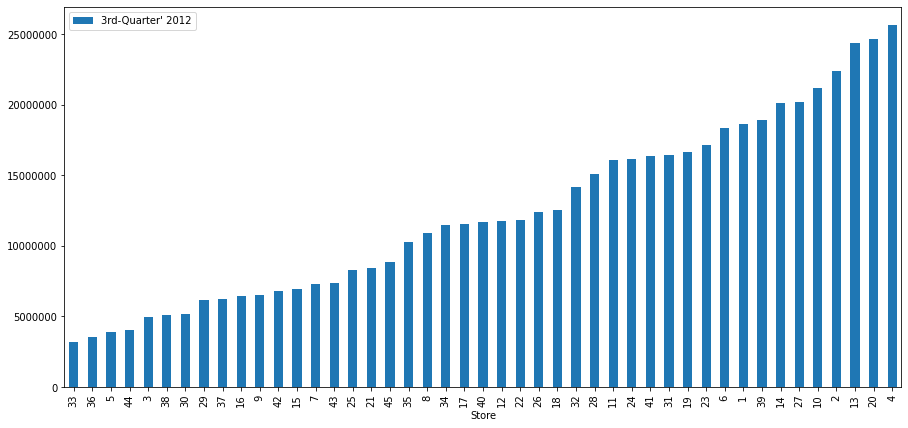

In [25]:
#con este script se muestra en crecimiento tercer trimestre 2012 por tienda

third_quarter= df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum().sort_values()
plt.figure(figsize=(15,7))
third_quarter.plot(kind='bar',legend=True)
plt.ticklabel_format( style='plain', axis='y')
plt.legend(["3rd-Quarter' 2012"]);

#plt.figure(figsize=(15,7))
#plt.scatter(df[df.Year==2010]["Month"],df[df.Year==2010]["Weekly_Sales"])
#plt.xlabel("Months")
#plt.ylabel("Weekly Sales")
#plt.title("Monthly view of sales in 2010")
#plt.show()


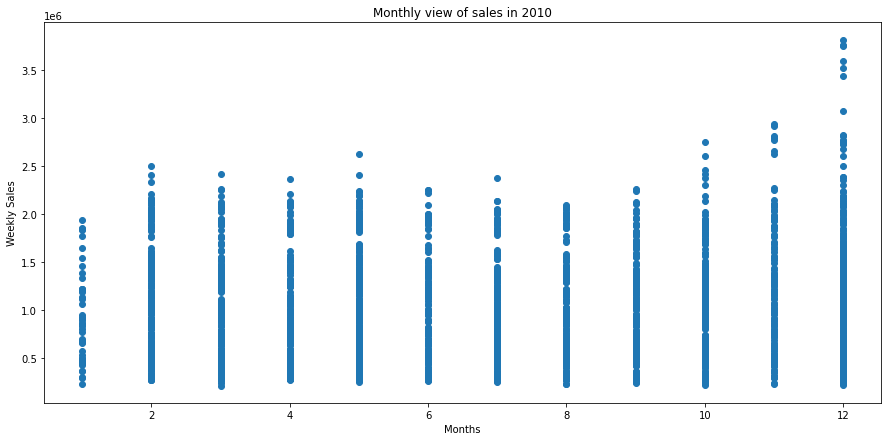

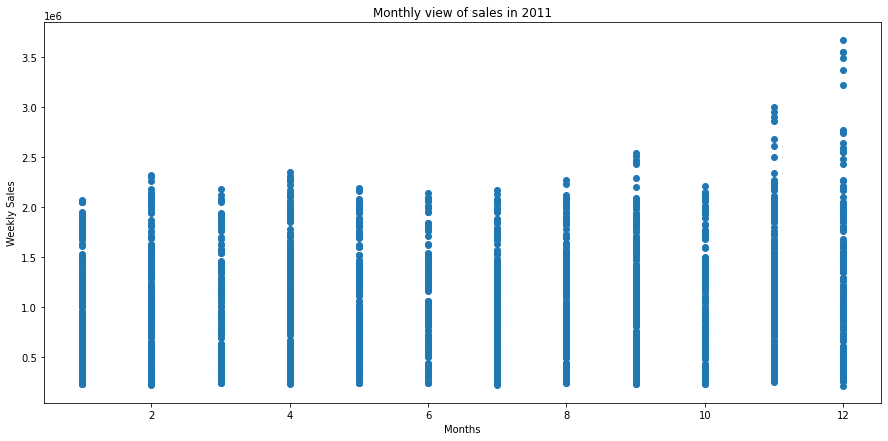

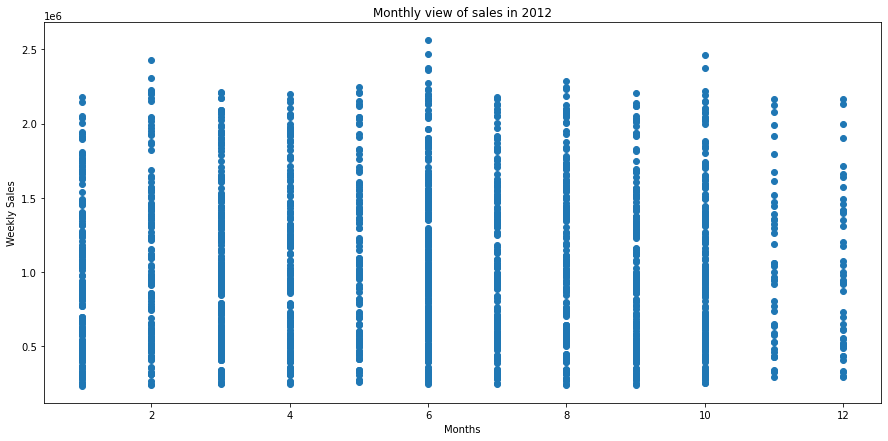

In [26]:
#con este script se pide a Python graficar las Ventas mensuales por cada año 

plt.figure(figsize=(15,7))
plt.scatter(df[df.Year==2010]["Month"],df[df.Year==2010]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.figure(figsize=(15,7))
plt.scatter(df[df.Year==2011]["Month"],df[df.Year==2011]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.figure(figsize=(15,7))
plt.scatter(df[df.Year==2012]["Month"],df[df.Year==2012]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

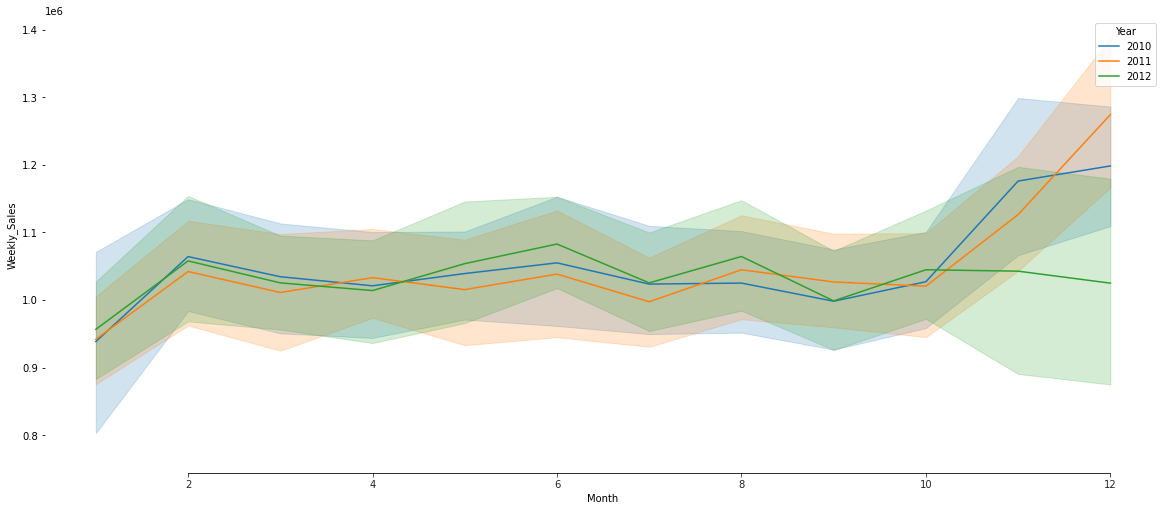

In [27]:
#con esta instrucción se pide a Python graficar las ventas de los tres años de manera mensual

plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)

plt.show()

# sección 3. **Modelado**
en esta sección del codigo se procede a realizar el modelado de la información

In [28]:
fig = px.box(data_sort, y = "Weekly_Sales", x = "Store",  color = "Store")
fig.show()

In [29]:
#df[(df['Date'] - pd.to_datetime('2010-02-12')).abs().min()==(df['Date'] - pd.to_datetime('2010-02-12')).abs()]

In [30]:
#sns.set_theme(style='darkgrid')
#plt.figure(figsize(20,8))
#sns.lineplot(data=store1, x='Date', y='Weekly_Sales', hue='Store', palette='tab10')
#plt.show()

# sección 4. **Quitar Valores de Rango**


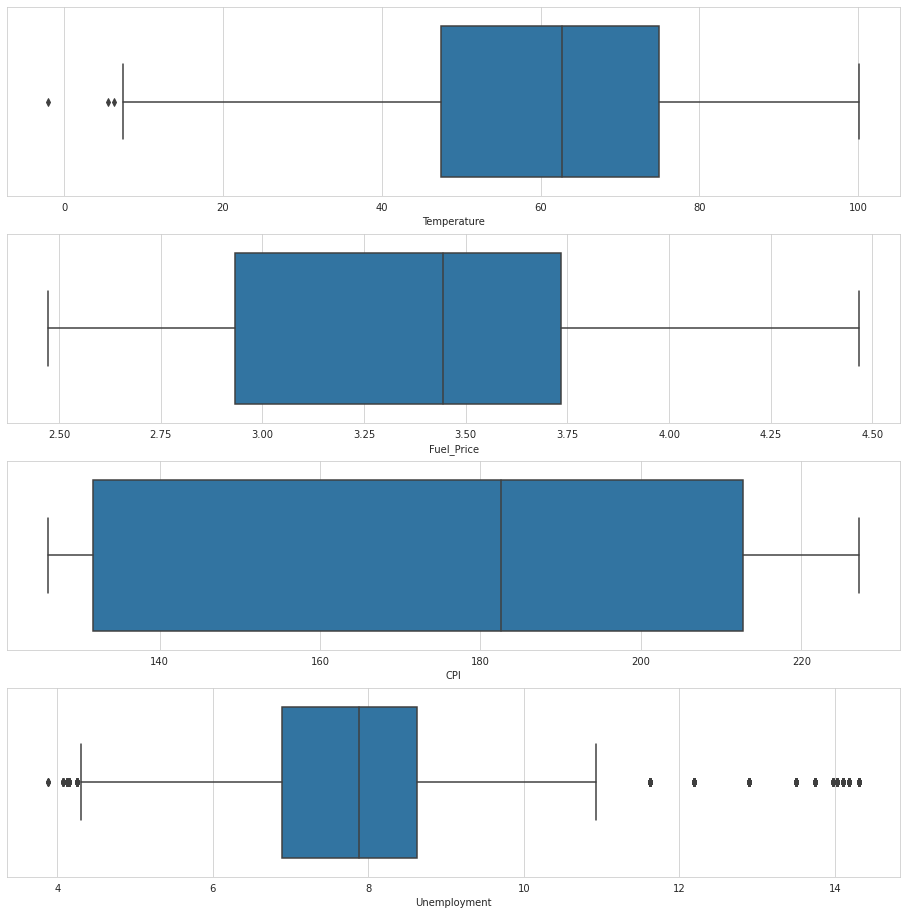

In [31]:
#con este script se validan los valores atipicos

fig, axis = plt.subplots(4,figsize=(16,16))
X = df[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df[column],ax=axis[i])


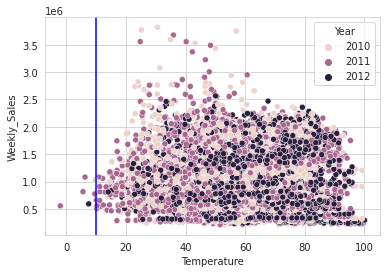

In [38]:
sns.scatterplot(data=df,x='Temperature', y='Weekly_Sales', hue='Year')
plt.axvline(x=10,color='b')

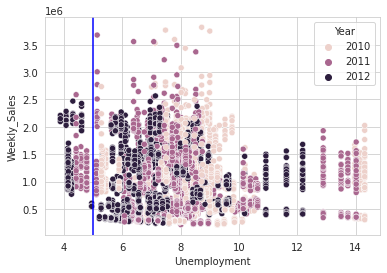

In [39]:
sns.scatterplot(data=df,x='Unemployment', y='Weekly_Sales', hue="Year")
plt.axvline(x=5,color='b')

In [34]:
# Quitamos valores atipicos en una nueva función
df_limpia = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]


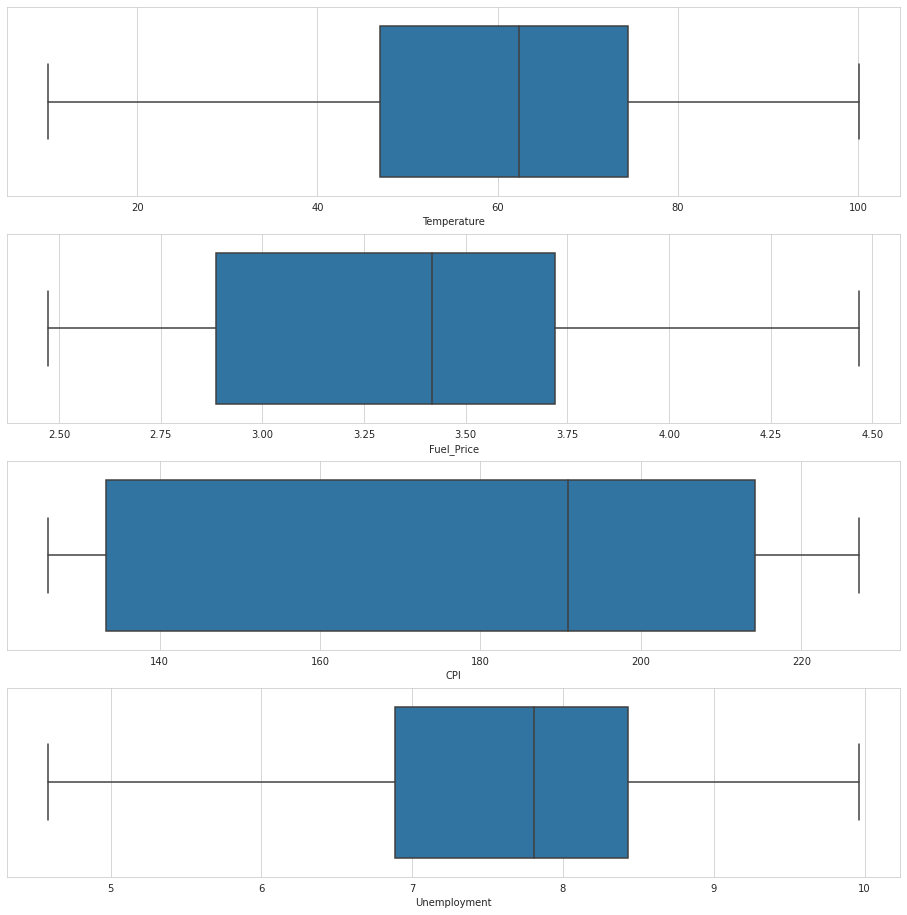

In [35]:
# Verificamos ya no tener valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_limpia[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_limpia[column],ax=axis[i])


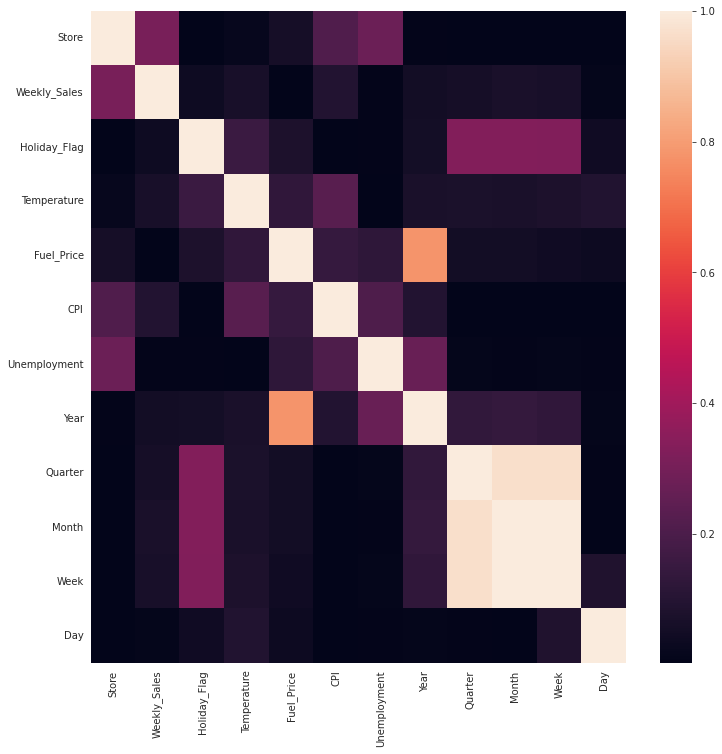

In [36]:
#con este grafico podemos ver las correlaciones de las diferentes columnas

plt.figure(figsize = (12,12))
sns.heatmap(df_limpia.corr().abs())    

plt.show()

In [37]:
#plt.figure(figsize=(20,8))
#sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
#plt.show()